### Some useful libraries

In [118]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('../')
sys.path.append('../libs_python')

# data munging and analytical libraries 
import re
import os
import numpy as np
import iris

# graphical libraries
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs
from   plot_maps       import *
from   ExtractLocation import *
from   listdir_path    import *
import jules
import convertpoints2grid

# setup nice plotting
plt.style.use('ggplot')#
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


I only got a chance to grab 2000-2005 climate data before catching the train, so thats the time period we going to average over

In [119]:
start_year = 2000
end_year   = 2005

Where out jules output, cci "obs" and driving data are from

In [120]:
jules_dir = '../../fireMIPbenchmarking/data/ModelOutputs/JULES-INFERNO-S2/'
rain_dir  = '../data/CRUNCEP/rain/'
tair_dir  = '../data/CRUNCEP/tair/'
cci       = '../data/qrparm.veg.frac.nc'

### Load JULES

In [121]:
### Switch to 9-pft ukesm dataset
## 

def open_files_annual_average(dir, s, e, FUN = jules, *arg, **kw):
    files = listdir_path(dir)
    years = np.array([int(file[s:e]) for file in files])
    files = np.array(files)
    files = files[(years >= start_year) & (years <= end_year)]
    dat = FUN.load(files, *arg, **kw)
    
    for i in dat[1:]: dat[0].data += i.data
    dat = dat[0] / len(dat)
    return(dat)

In [122]:
pft_name    = ['BL', 'NL','C3G', 'C4G', 'SH', 'Bare Soil']
layer_no    = [0   , 1   , 2   , 3    , 4    , 7         ]

frac_cover_jules = open_files_annual_average(jules_dir, -7, -3, jules, "Fractional cover of each surface type")
frac_cover_jules = frac_cover_jules
frac_cover_jules = frac_cover_jules.collapsed('time', iris.analysis.MEAN)[layer_no]

C:\Users\dougl\Anaconda3\lib\site-packages\iris\coords.py:1000: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\dougl\Anaconda3\lib\site-packages\iris\coords.py:1000: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\dougl\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


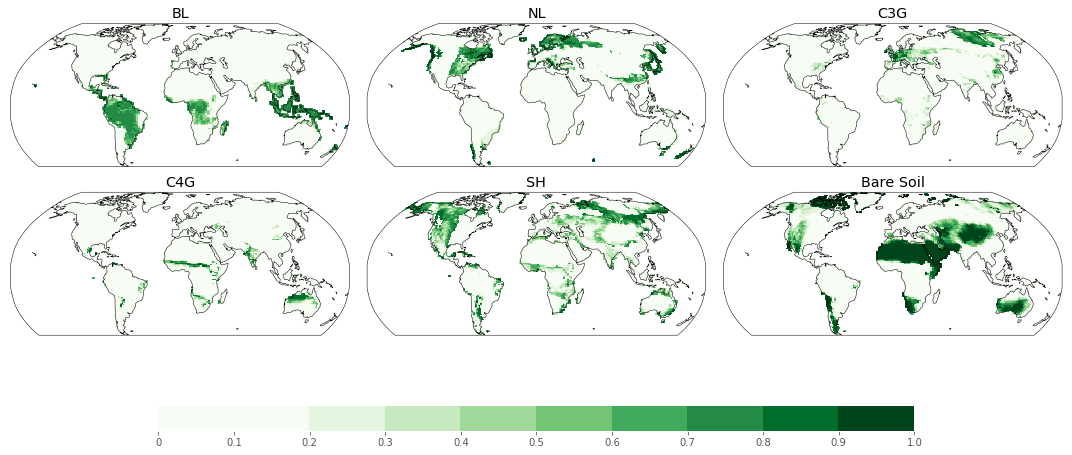

In [123]:
cover_levels  = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cover_dlevels = [-0.5, -0.4, -0.3, -0.2, -0.1, -0.05, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

def plot_cover_data(cubes, cmap = 'brewer_Greens_09', levels = cover_levels, *args, **kw):
    plot_cubes_map(cubes, pft_name, cmap, levels, ny = 3, 
                   figXscale = 2.5, figYscale = 0.6, *args, **kw)

plot_cover_data(frac_cover_jules)

### Load CCI

C:\Users\dougl\Anaconda3\lib\site-packages\iris\coords.py:1000: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\dougl\Anaconda3\lib\site-packages\iris\coords.py:1000: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\dougl\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


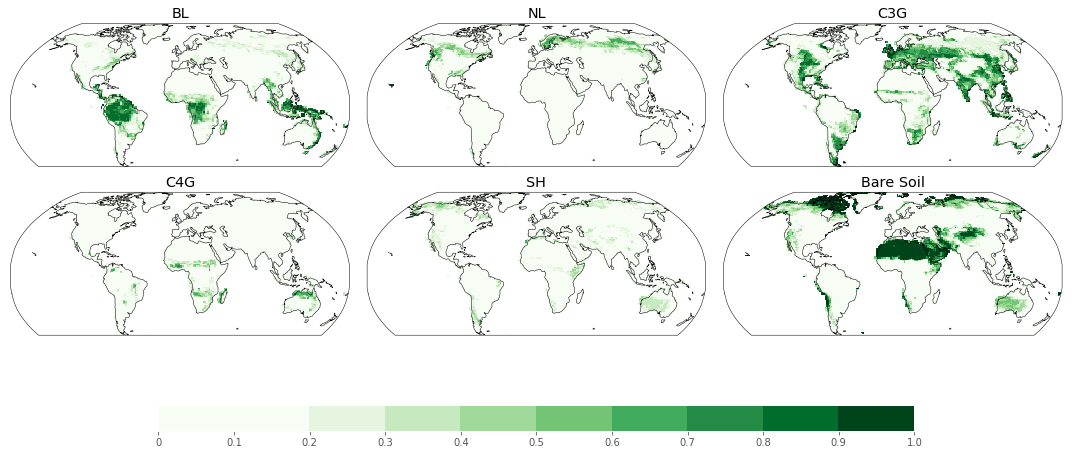

In [144]:
frac_cover_cci = iris.load_cube(cci)[layer_no]

def addLatLon(cube):
    cubei = frac_cover_jules[0].copy()
    cubei.data = cube.data[-118:-6:,]
    return(cubei)

def addLatLons(cube):
    index = range(0, cube.shape[0])
    cubei = frac_cover_jules[index].copy()
    for i in index: cubei.data[i] = cube.data[i][-117:-5:,]
    return(cubei)

frac_cover_cci = addLatLons(frac_cover_cci)
plot_cover_data(frac_cover_cci)

## IGPP, CCI error bars

C:\Users\dougl\Anaconda3\lib\site-packages\iris\coords.py:1000: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\dougl\Anaconda3\lib\site-packages\iris\coords.py:1000: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\dougl\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


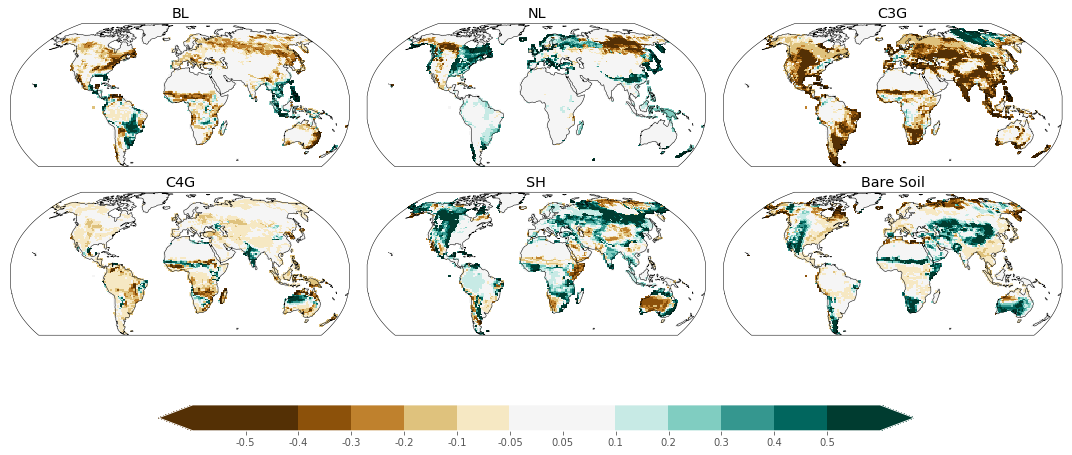

In [145]:
frac_cover_diff = frac_cover_jules.copy()
frac_cover_diff.data -= frac_cover_cci.data
frac_cover_diff
plot_cover_data(frac_cover_diff, "brewer_BrBG_11", cover_dlevels, extend = 'both')

### Load climate

### Rainfall
We'll load rain to start with. We going to look at mean annual precip and seasonality in precip. Inert annual variability might also be a good idea... just not from only 6 years of climate obs

In [146]:
rain = open_files_annual_average(rain_dir, -11, -7, iris, "Total_Precipitation")

C:\Users\dougl\Anaconda3\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'time' invalid units 'day as %Y%m%d.%f'
  warnings.warn(msg)
C:\Users\dougl\Anaconda3\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:2076: UserWarning: Failed to create 'time' dimension coordinate: The points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  error=e_msg))
C:\Users\dougl\Anaconda3\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'time' invalid units 'day as %Y%m%d.%f'
  warnings.warn(msg)
C:\Users\dougl\Anaconda3\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:2076: UserWarning: Failed to create 'time' dimension coordinate: The points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  error=e_msg))
C:\Users\dou

#### Mean Annual Percip (MAP)

In [147]:
MAP = rain.collapsed('time', iris.analysis.SUM) * 60 * 60 * 4
MAP = addLatLon(MAP)

C:\Users\dougl\Anaconda3\lib\site-packages\iris\coords.py:1210: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


#### Seasonality

In [148]:
nt = rain.shape[0]
x = np.arange(0, 1, 1.0/nt) * 2 * np.pi
y = np.sin(x)
x = np.cos(x)



rain_x = rain.copy()
rain_y = rain.copy()

for i in range(0, nt): 
    rain_x.data[i] = rain.data[i] * x[i]
    rain_y.data[i] = rain.data[i] * y[i]
    

rain_x = rain_x.collapsed('time', iris.analysis.SUM)
rain_y = rain_y.collapsed('time', iris.analysis.SUM)


rain_v = np.power(rain_x, 2) + np.power(rain_y, 2)
rain_v = np.power(rain_v, (1/2))
rain_c = rain_v/rain.collapsed('time', iris.analysis.SUM)

rain_c = addLatLon(rain_c)


C:\Users\dougl\Anaconda3\lib\site-packages\iris\coords.py:1210: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


#### Rainfall mertics

C:\Users\dougl\Anaconda3\lib\site-packages\iris\coords.py:1000: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\dougl\Anaconda3\lib\site-packages\iris\coords.py:1000: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


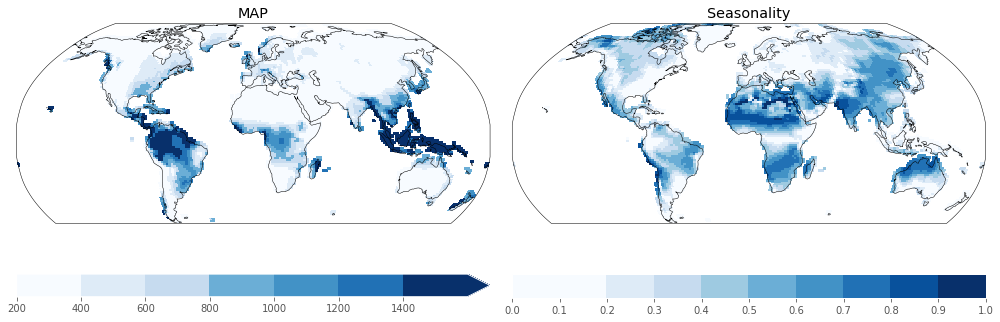

In [149]:
MAP.long_name = 'MAP'
rain_c.long_name = 'Seasonality'

plt.figure(figsize = (14, 5))
plot_lonely_cube(MAP   , 1, 2, 1, cmap = "brewer_Blues_09", levels = [200, 400, 600, 800, 1000, 1200, 1400], extend = 'max')
plot_lonely_cube(rain_c, 1, 2, 2, cmap = "brewer_Blues_09", levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

### Air temp

In [150]:
tair = open_files_annual_average(tair_dir, -11, -7, iris, "Temperature")

C:\Users\dougl\Anaconda3\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'time' invalid units 'day as %Y%m%d.%f'
  warnings.warn(msg)
C:\Users\dougl\Anaconda3\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:2076: UserWarning: Failed to create 'time' dimension coordinate: The points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  error=e_msg))
C:\Users\dougl\Anaconda3\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'time' invalid units 'day as %Y%m%d.%f'
  warnings.warn(msg)
C:\Users\dougl\Anaconda3\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:2076: UserWarning: Failed to create 'time' dimension coordinate: The points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  error=e_msg))
C:\Users\dou

In [151]:
MAT = tair.collapsed('time', iris.analysis.MEAN) -273.15
MAT = addLatLon(MAT)

C:\Users\dougl\Anaconda3\lib\site-packages\iris\coords.py:1210: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


In [152]:
MxAT = tair.collapsed('time', iris.analysis.MAX) -273.15
MxAT = addLatLon(MxAT)

C:\Users\dougl\Anaconda3\lib\site-packages\iris\coords.py:1210: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


C:\Users\dougl\Anaconda3\lib\site-packages\iris\coords.py:1000: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\dougl\Anaconda3\lib\site-packages\iris\coords.py:1000: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


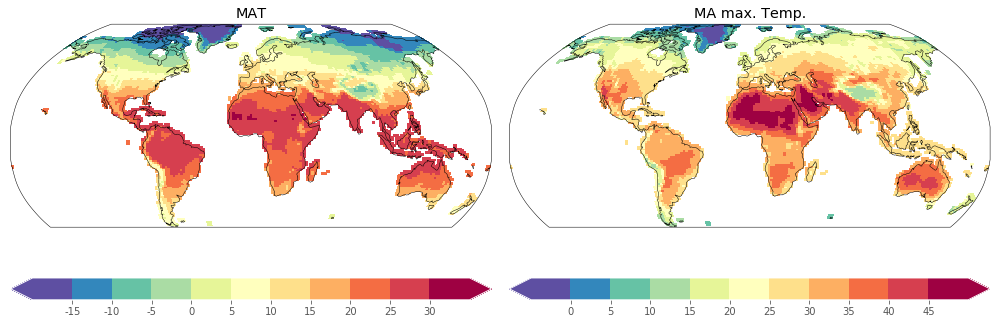

In [153]:
MAT.long_name = 'MAT'
MxAT.long_name = 'MA max. Temp.'

plt.figure(figsize = (14, 5))

plot_lonely_cube(MAT , 1, 2, 1, cmap = "Spectral_r", levels = [-15, -10, -5, 0, 5, 10, 15, 20, 25, 30], extend = 'both')
plot_lonely_cube(MxAT, 1, 2, 2, cmap = "Spectral_r", levels = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45], extend = 'both')

## Veg frac climate zone
So, we have frac_cover from jules, frac_cover_cci from observations. And we'll see where in MAP, rain_c, MAT, MxAT they fall.

In [248]:
from pdb import set_trace as browser
def plot3BiomCLim (ax, x, y, z, title, xlim = None, ylim = None, cmap = 'RdYlGn_r', levels = cover_levels, alpha = 0.01):
    zs  = z.data.copy()
    zsi = zs.copy()

    zsi[:] = 0
    zsi[zs >= levels[-1]] = len(levels)
    
    for i, mn, mx in zip(range(len(levels) - 1), levels[:-1], levels[1:]):
        zsi[(zs > mn) & (zs < mx)] = i
    
    for i in [200, 150, 100, 75, 50, 25, 10, 5, 2, 1]:
        cf = ax.scatter(x.data, y.data, c = zsi, cmap = cmap, s = i, alpha = alpha)
    
    ax.set_title(title)
    if xlim is not None: ax.set_xlim(xlim)
    if ylim is not None: ax.set_ylim(ylim)
    #plt.colorbar(cf)
    #addColorbar(cf, levels, extend = 'both')
        
def extractArea(cubes, extent):
    return(ExtractLocation(cubes, extent[0], extent[1], extent[2], extent[3]).cubes)
   
def plotJulesCCI(x, y, title = '', pft = 5, extent = None, *args, **kw):
    
    if extent is not None:
        x = extractArea(x, extent)
        y = extractArea(y, extent)          
        z1 = extractArea(frac_cover_cci[pft], extent)
        z2 = extractArea(frac_cover_jules[pft], extent)
        
        #z3 = extractArea(frac_cover_diff[pft], extent)
    else:
        z1 = frac_cover_cci[pft]
        z2 = frac_cover_jules[pft]
        #z3 = frac_cover_diff[pft]
    
    plt.rcParams['figure.figsize'] = (16, 5)
    fig, ax = plt.subplots(1,3, sharey=True)    
    plot3BiomCLim(ax[0], x, y, z1, 'CCI', *args, **kw)    
    plot3BiomCLim(ax[1], x, y, z2, 'JULES', *args, **kw)
    plot3BiomCLim(ax[2], x, y, z1 - z2, '"Difference (something might wrong here :S)"', levels = cover_dlevels, *args, **kw)
    
    plt.gcf().suptitle(title, fontsize=14)



C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


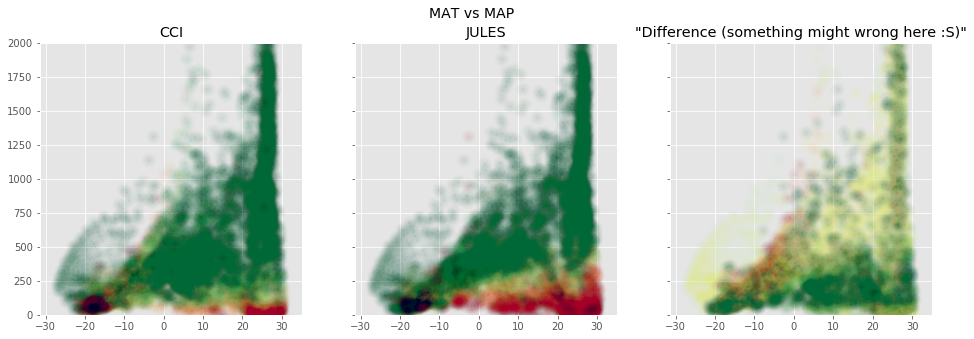

In [249]:
plotJulesCCI(MAT, MAP, 'MAT vs MAP', ylim = [0, 2000])

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


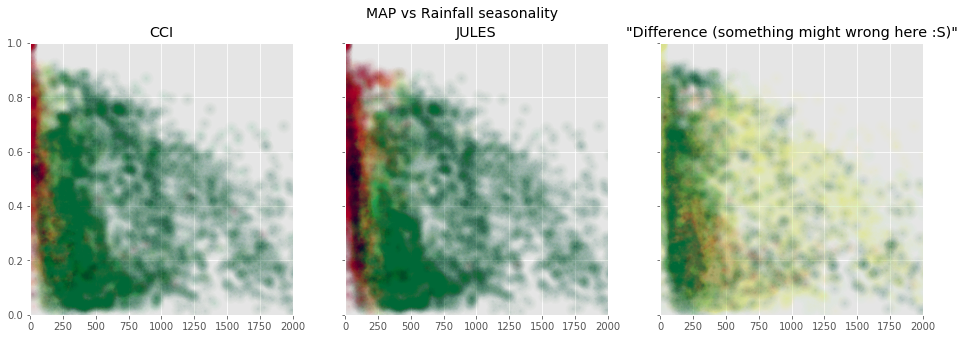

In [250]:
plotJulesCCI(MAP, rain_c,'MAP vs Rainfall seasonality', xlim = [0, 2000], ylim = [0, 1])

### Australia

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


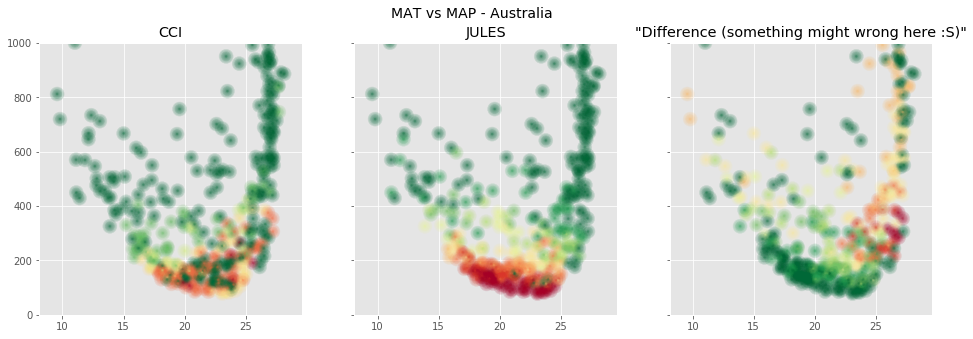

In [251]:
plotJulesCCI(MAT, MAP,'MAT vs MAP - Australia', extent = [110, 160, -50, -10], ylim = [0, 1000], alpha = 0.1)

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


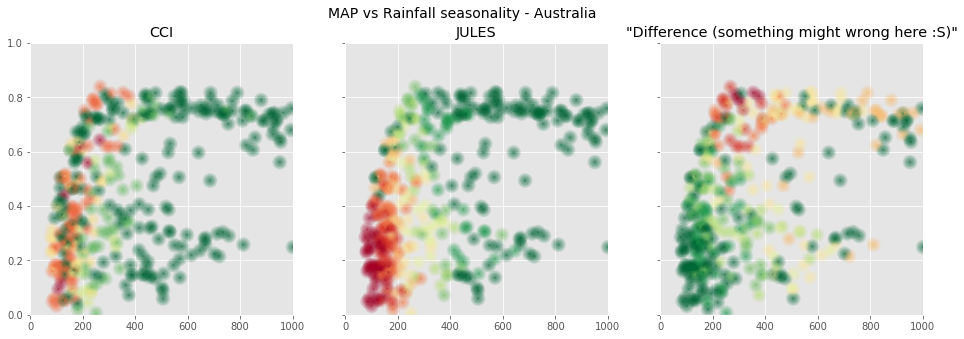

In [252]:
plotJulesCCI(MAP, rain_c,'MAP vs Rainfall seasonality - Australia', extent = [110, 160, -50, -10], xlim = [0, 1000], ylim = [0, 1], alpha = 0.1)

**Look at Veg Frac seasonailty**

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


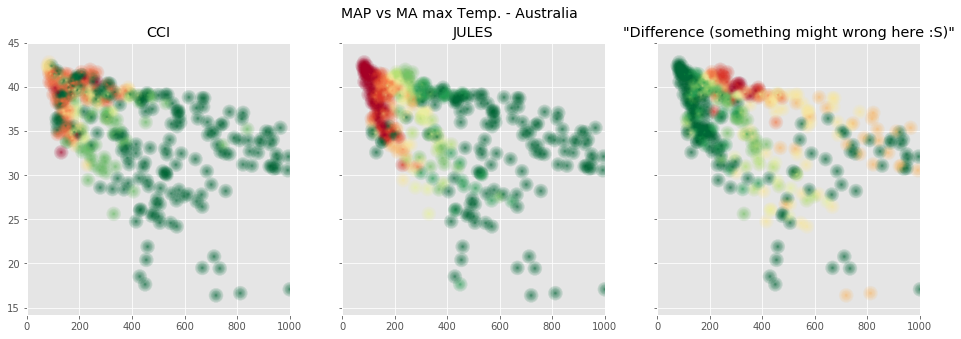

In [253]:
plotJulesCCI(MAP, MxAT,'MAP vs MA max Temp. - Australia', extent = [110, 160, -50, -10], xlim = [0, 1000], alpha = 0.1)

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


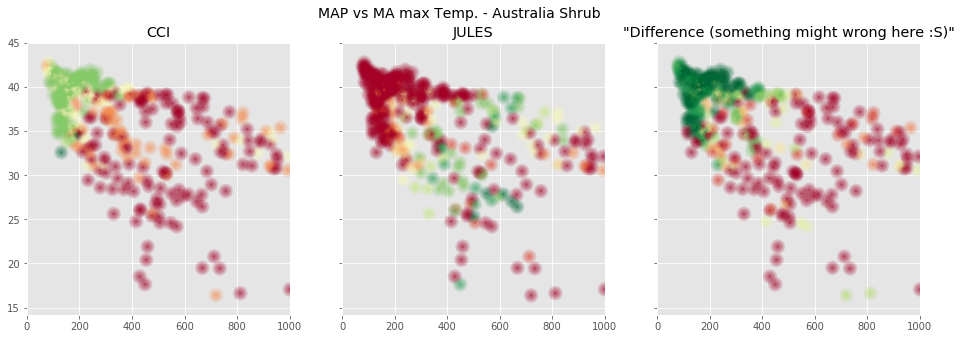

In [254]:
plotJulesCCI(MAP, MxAT,'MAP vs MA max Temp. - Australia Shrub', pft = 4, extent = [110, 160, -50, -10], cmap = 'RdYlGn', xlim = [0, 1000], alpha = 0.1)

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


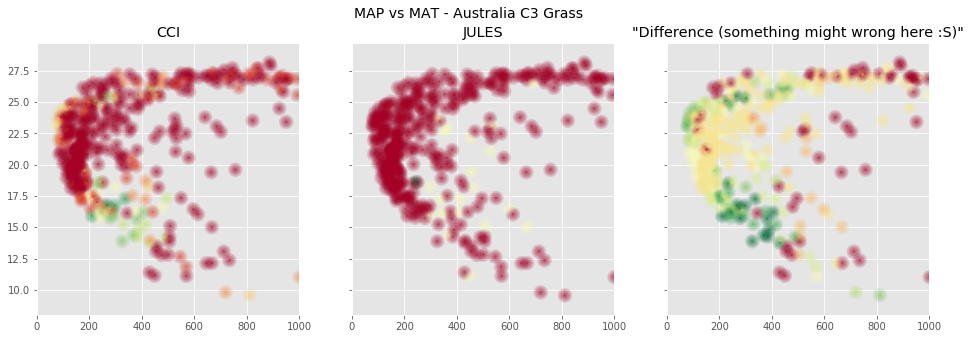

In [255]:
plotJulesCCI(MAP, MAT,'MAP vs MAT - Australia C3 Grass', pft = 2, extent = [110, 160, -50, -10], cmap = 'RdYlGn', xlim = [0, 1000], alpha = 0.1)

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


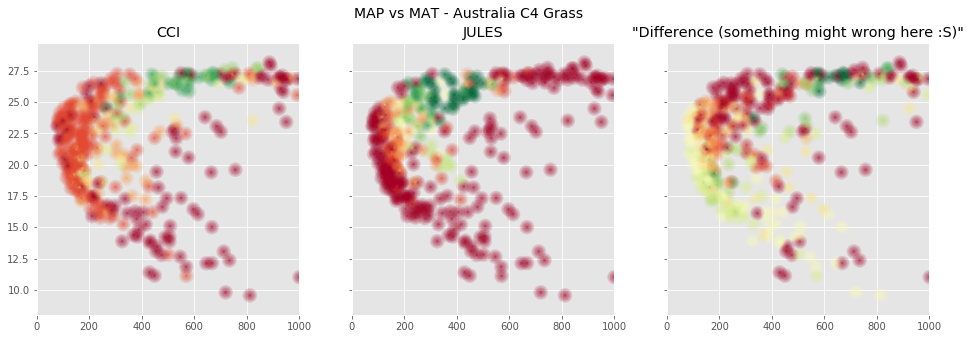

In [256]:
plotJulesCCI(MAP, MAT,'MAP vs MAT - Australia C4 Grass', pft = 3, extent = [110, 160, -50, -10], cmap = 'RdYlGn', xlim = [0, 1000], alpha = 0.1)

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


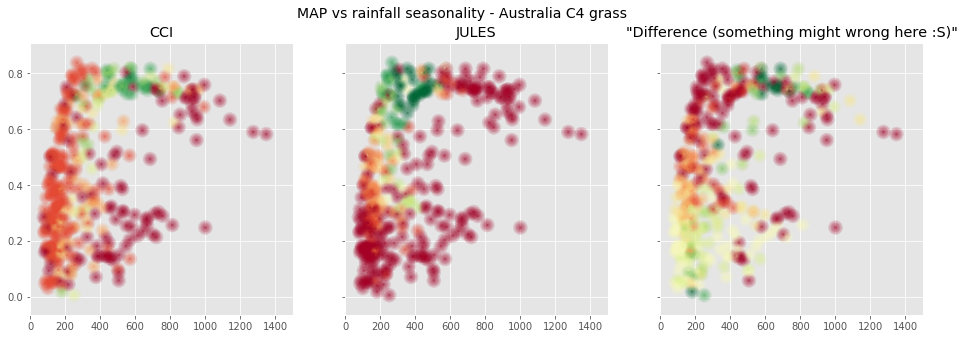

In [257]:
plotJulesCCI(MAP, rain_c,'MAP vs rainfall seasonality - Australia C4 grass', pft = 3, extent = [110, 160, -50, -10], cmap = 'RdYlGn', xlim = [0, 1500], alpha = 0.1)

### Central Asia

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


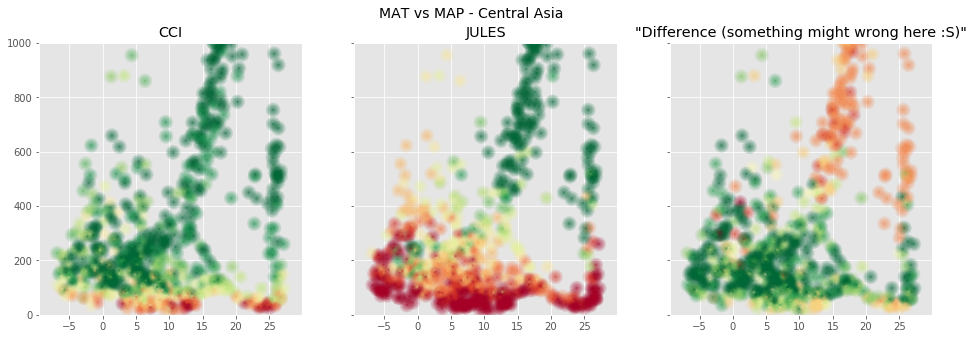

In [258]:
plotJulesCCI(MAT, MAP,'MAT vs MAP - Central Asia', extent = [60, 120, 25, 50], ylim = [0, 1000], alpha = 0.1)

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


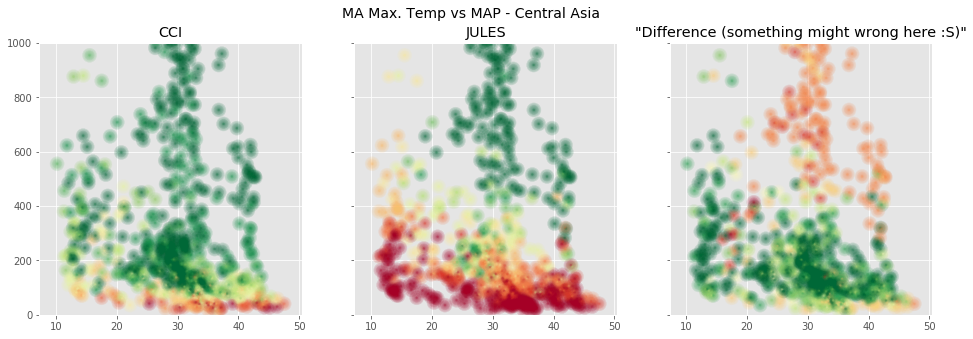

In [259]:
plotJulesCCI(MxAT, MAP,'MA Max. Temp vs MAP - Central Asia', extent = [60, 120, 25, 50], ylim = [0, 1000], alpha = 0.1)

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


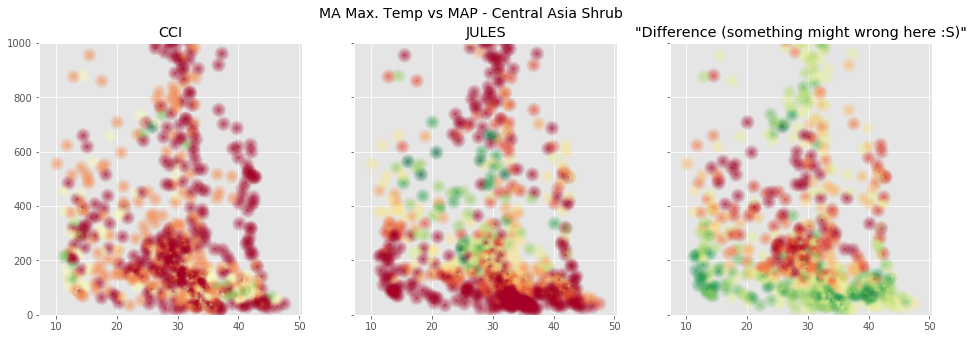

In [260]:
plotJulesCCI(MxAT, MAP,'MA Max. Temp vs MAP - Central Asia Shrub', cmap = 'RdYlGn', pft = 4,extent = [60, 120, 25, 50], ylim = [0, 1000], alpha = 0.1)

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


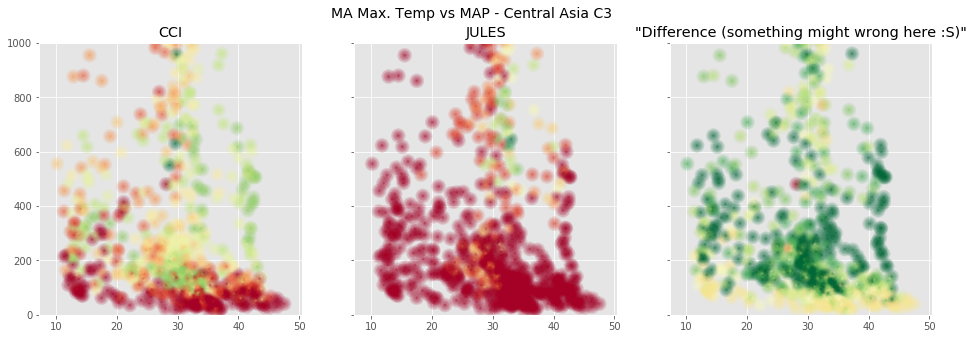

In [261]:
plotJulesCCI(MxAT, MAP,'MA Max. Temp vs MAP - Central Asia C3', cmap = 'RdYlGn', pft = 2,extent = [60, 120, 25, 50], ylim = [0, 1000], alpha = 0.1)

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


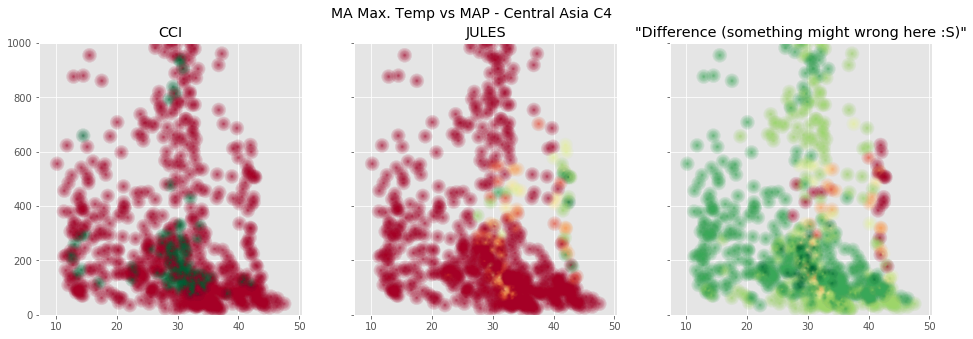

In [262]:
plotJulesCCI(MxAT, MAP,'MA Max. Temp vs MAP - Central Asia C4', cmap = 'RdYlGn', pft = 3, extent = [60, 120, 25, 50], ylim = [0, 1000], alpha = 0.1)

### Sahel

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


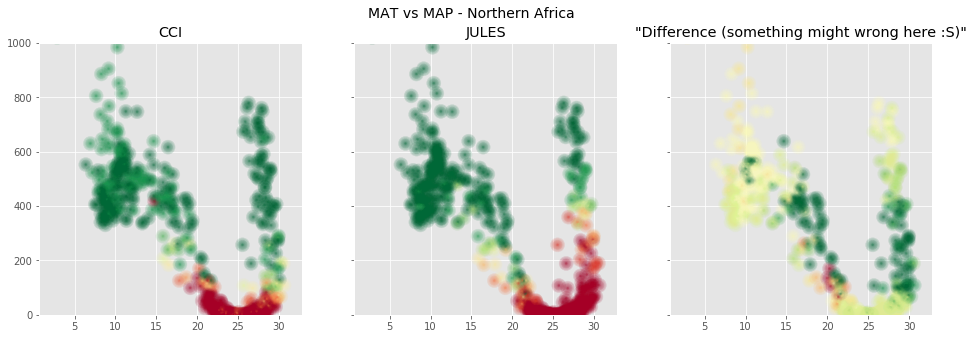

In [268]:
plotJulesCCI(MAT, MAP,'MAT vs MAP - Northern Africa', extent = [0, 25, 10, 55], ylim = [0, 1000], alpha = 0.1)

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


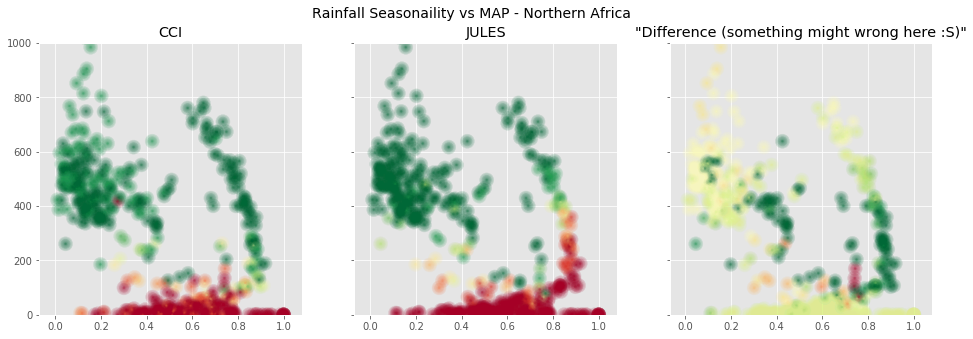

In [264]:
plotJulesCCI(rain_c, MAP,'Rainfall Seasonaility vs MAP - Northern Africa', extent = [0, 25, 10, 55], ylim = [0, 1000], alpha = 0.1)

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


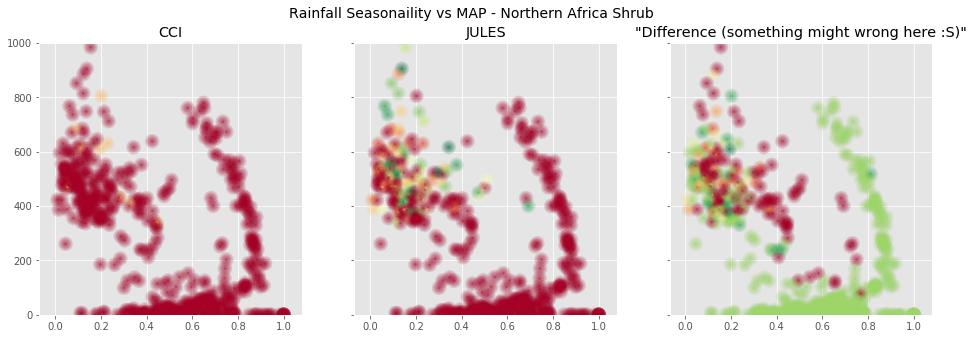

In [265]:
plotJulesCCI(rain_c, MAP,'Rainfall Seasonaility vs MAP - Northern Africa Shrub', cmap = 'RdYlGn', pft = 1,extent = [0, 25, 10, 55], ylim = [0, 1000], alpha = 0.1)

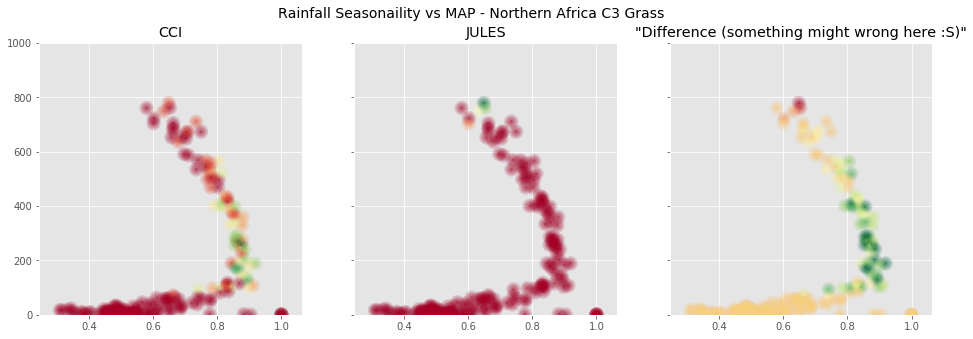

In [266]:
plotJulesCCI(rain_c, MAP,'Rainfall Seasonaility vs MAP - Northern Africa C3 Grass', cmap = 'RdYlGn', pft = 2, extent = [0, 25, 10, 25], ylim = [0, 1000], alpha = 0.1)

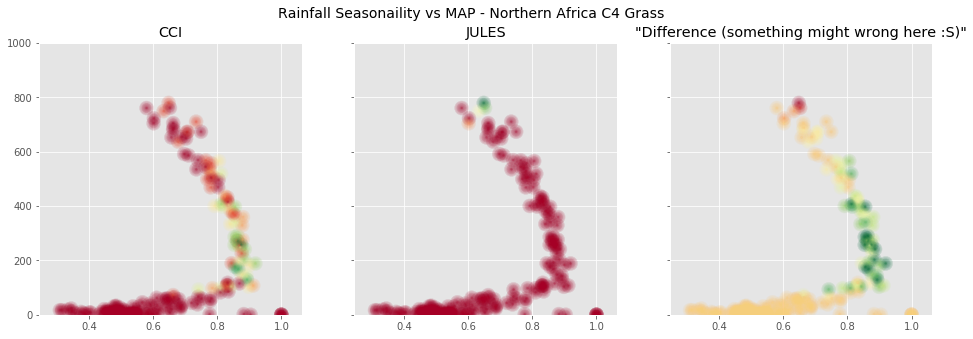

In [267]:
plotJulesCCI(rain_c, MAP,'Rainfall Seasonaility vs MAP - Northern Africa C4 Grass', cmap = 'RdYlGn', pft = 2, extent = [0, 25, 10, 25], ylim = [0, 1000], alpha = 0.1)

Replce with UKESM setup - Doug (job from Andy)
cci -time period etc.

Soil mositure
TIme period obs.
Trends in Veg frac.
if so, too much ET?
    Turn off soil moisture E soil (soil_evap = 0) (see MB/NG) (Doug, Rich)
    AMA sites/ KW sites
    AW - benchmarking with 9 PFTs/UKESM setup
    Description of CABLE ET reudction KW.
    
    
(IF soil moistures not good). Respration - turn off (Andy W)
Lina - Thigh.
Prescribed veg run - see if things will grow - LAI, MPP, ET. (suite KW).
